In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib import pyplot as plt

%matplotlib inline
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 18
plt.rcParams["figure.figsize"] = (16,9)
plt.rcParams["axes.unicode_minus"] = False

# 0.Data Load
---

In [3]:
df_prch = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_02_PDDE.csv", low_memory=False)
df_prod = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_04_PD_CLAC.csv")

In [3]:
df_prch.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1


In [4]:
df_merge = pd.merge(left=df_prch, right=df_prod, on="pd_c", how="left")
df_merge.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,pd_nm,clac_hlv_nm,clac_mcls_nm
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1,남성티셔츠,남성의류,남성의류상의
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1,기타주방일회용품,주방잡화,주방일회용품
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1,남성티셔츠,남성의류,남성의류상의


In [5]:
df_pt = pd.pivot_table(
                data=df_merge,
                values = "buy_am",       # 테이블을 채울 값
                index = "cust",          # 좌측(인덱스) 기준 -> 행 기준
                columns = "clac_hlv_nm", # 컬럼 -> 열 기준
                aggfunc = "sum",         # 어떤 방식으로 합칠지
                fill_value = 0)          # NaN 처리

# 1.초기 논리 설계 구현
---

## 1.1.장바구니 연관성이 높지만, 구매하지 않은 품목 추천
---

1. 90일 window 데이터 기반 연관 규칙 도출 (해당 과정에서 상품 유사도를 측정하여 적용하면 좋을 듯)
2. 고객 한 명당 90일 구매 데이터의 value_counts 측정
3. 아래 사항 case 처리
    - value_counts가 높은 순으로 연관 규칙 적용 (1달 이내 구매할 만큼 구매가 빈번한 상품)
    - 최근 구매 순으로 연관 규칙 적용 (가장 최근 구매가 다음 구매에 영향을 미친다는 논리 적용)
    > - 유사도가 특정치 이상이거나,  충분히 빈발한 구매 품목에 대해 굳이 추천하지 않도록
4. 연관 규칙에 의해 도출된 품목 3가지 투입

### 1.1.1. 90일 윈도우 연관 규칙 도출
---

In [6]:
# -- 1. 90일 윈도우 기반 연관 규칙
## -- 1.1. 시간 순으로 90일 윈도우 생성하는 함수
df_prch["de_dt"]=pd.to_datetime(df_prch["de_dt"].astype(str))

from datetime import datetime, timedelta

def windows90(df, start, window=None):
    start = datetime.strptime(start, "%Y-%m-%d")
    # end = datetime.strptime(end, "%Y-%m-%d")
    if window is None:
        window=[date.strftime("%Y-%m-%d") for date in pd.date_range(start=start, periods=90)]
    else:
        window=window[1:]+[window[-1]+timedelta(days=1)]
    return df.loc[df["de_dt"].isin(window)]

windows90(df_prch, "2021-01-01")

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1
1,M646853852,A01000002265,1,A01,A010025,PD1369,2021-01-01,10,79700.0,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1
3,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1
4,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1
...,...,...,...,...,...,...,...,...,...,...
4339259,M206715364,E06023586868,2,A06,NaN,PD0981,2021-03-31,23,110000.0,1
4339260,M585664062,E06023587628,2,A06,NaN,PD0620,2021-03-31,23,4450.0,5
4339261,M206715364,E06023588335,2,A06,NaN,PD0981,2021-03-31,23,110000.0,1
4339262,M206715364,E06023588335,2,A06,NaN,PD0981,2021-03-31,23,110000.0,1


In [7]:
## -- 1.2. 연관 규칙 도출 (상품 유사도 측정 X)
df_first90 = windows90(df_prch, "2021-01-01")
product_list_per_order = df_first90.groupby("rct_no")["pd_c"].apply(list)
product_list_per_order

rct_no
A01000001113            [PD0290]
A01000002265            [PD1369]
A01000003148    [PD0290, PD0290]
A01000004946            [PD0290]
A01000005297            [PD1692]
                      ...       
E06023585457    [PD0981, PD0981]
E06023586868            [PD0981]
E06023587628            [PD0620]
E06023588335    [PD0981, PD0981]
E06023589803            [PD0613]
Name: pd_c, Length: 316024, dtype: object

In [8]:
from mlxtend.preprocessing import TransactionEncoder

encoder = TransactionEncoder()
one_hot_df = encoder.fit(product_list_per_order).transform(product_list_per_order)
one_hot_df = pd.DataFrame(one_hot_df, columns=encoder.columns_)
one_hot_df.head()

,PD0001,PD0002,PD0003,PD0004,PD0005,PD0006,PD0007,PD0008,PD0009,PD0010,...,PD1924,PD1925,PD1926,PD1927,PD1928,PD1929,PD1930,PD1931,PD1932,PD1933
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
from mlxtend.frequent_patterns import *

frequent_item_df = apriori(one_hot_df, min_support=.003)
result = association_rules(frequent_item_df, metric="confidence", min_threshold=.1)
result

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(166),(171),0.015667,0.039918,0.003481,0.222177,5.565864,0.002855,1.234320
1,(166),(1101),0.015667,0.070520,0.003361,0.214502,3.041722,0.002256,1.183301
2,(177),(171),0.015549,0.039918,0.003107,0.199837,5.006211,0.002487,1.199859
3,(171),(189),0.039918,0.032846,0.005667,0.141974,4.322461,0.004356,1.127185
4,(189),(171),0.032846,0.039918,0.005667,0.172543,4.322461,0.004356,1.160281
...,...,...,...,...,...,...,...,...,...
260,"(1427, 390)",(1101),0.008503,0.070520,0.003038,0.357276,5.066307,0.002438,1.446157
261,"(1101, 390)",(1427),0.011322,0.048765,0.003038,0.268306,5.501994,0.002486,1.300045
262,"(1330, 1427)",(1101),0.010759,0.070520,0.003427,0.318529,4.516869,0.002668,1.363933
263,"(1330, 1101)",(1427),0.010746,0.048765,0.003427,0.318905,6.539582,0.002903,1.396625


In [10]:
result.sort_values(by="confidence", ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
145,(391),(390),0.015299,0.044408,0.006493,0.424405,9.556953,0.005814,1.660182
81,(222),(224),0.023312,0.055964,0.009822,0.421338,7.528726,0.008517,1.631413
169,(398),(1101),0.011306,0.070520,0.004357,0.385390,5.464984,0.003560,1.512310
236,(1369),(1330),0.012942,0.045035,0.004784,0.369682,8.208856,0.004202,1.515054
260,"(1427, 390)",(1101),0.008503,0.070520,0.003038,0.357276,5.066307,0.002438,1.446157
232,(1333),(1330),0.023213,0.045035,0.008240,0.354962,7.881988,0.007194,1.480479
178,(1098),(1101),0.030403,0.070520,0.010585,0.348147,4.936863,0.008441,1.425905
57,(211),(224),0.011790,0.055964,0.003791,0.321524,5.745190,0.003131,1.391407
263,"(1330, 1101)",(1427),0.010746,0.048765,0.003427,0.318905,6.539582,0.002903,1.396625
262,"(1330, 1427)",(1101),0.010759,0.070520,0.003427,0.318529,4.516869,0.002668,1.363933


In [11]:
result["antecedents"] = result["antecedents"].apply(lambda x: df_prod.loc[df_prod["pd_c"]==one_hot_df.columns[list(x)[0]]]["pd_nm"].values[0])
result["consequents"] = result["consequents"].apply(lambda x: df_prod.loc[df_prod["pd_c"]==one_hot_df.columns[list(x)[0]]]["pd_nm"].values[0])

In [12]:
result.sort_values(by="confidence", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
145,비빔봉지라면,국물봉지라면,0.015299,0.044408,0.006493,0.424405,9.556953,0.005814,1.660182
81,옥수수스낵,일반스낵,0.023312,0.055964,0.009822,0.421338,7.528726,0.008517,1.631413
169,일반시리얼,일반우유,0.011306,0.070520,0.004357,0.385390,5.464984,0.003560,1.512310
236,애호박,두부류,0.012942,0.045035,0.004784,0.369682,8.208856,0.004202,1.515054
260,일반계란,일반우유,0.008503,0.070520,0.003038,0.357276,5.066307,0.002438,1.446157
...,...,...,...,...,...,...,...,...,...
12,딸기,일반요구르트,0.039918,0.030403,0.004120,0.103210,3.394773,0.002906,1.081187
182,일반요구르트,생수,0.030403,0.029128,0.003133,0.103039,3.537516,0.002247,1.082402
5,딸기,감자스낵,0.039918,0.036377,0.004053,0.101546,2.791484,0.002601,1.072534
181,일반요구르트,치즈,0.030403,0.022182,0.003060,0.100645,4.537279,0.002386,1.087244


In [ ]:
# -- N일 윈도우 형성
df_prch["de_dt"]=pd.to_datetime(df_prch["de_dt"].astype(str))

from datetime import datetime, timedelta

def make_windows(df, start, col_nm, window=90):
    start = datetime.strptime(start, "%Y-%m-%d")
    # end = datetime.strptime(end, "%Y-%m-%d")
    window=[date.strftime("%Y-%m-%d") for date in pd.date_range(start=start, periods=window)]
    # window=window[1:]+[window[-1]+timedelta(days=1)]
    return df.loc[df[col_nm].isin(window)]

make_windows(df_prch, "2021-01-01", "de_dt", 30)

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1
1,M646853852,A01000002265,1,A01,A010025,PD1369,2021-01-01,10,79700.0,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1
3,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1
4,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1
...,...,...,...,...,...,...,...,...,...,...
4315205,M505778499,E06006404287,2,A06,NaN,PD0082,2021-01-30,23,34500.0,1
4315206,M788680851,E06006405265,2,A06,NaN,PD0238,2021-01-30,23,11980.0,1
4315207,M097157467,E06006406764,2,A06,NaN,PD1925,2021-01-30,23,11800.0,2
4315208,M410156270,E06006408006,2,A06,NaN,PD0082,2021-01-30,23,19900.0,1


In [11]:
# -- 연관 규칙 도출
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

def make_ASR(df, order, product, min_support=.003, min_confidence=.1):
    
    product_list_per_order = df.groupby(order)[product].apply(list)
    encoder = TransactionEncoder()
    one_hot_df = encoder.fit(product_list_per_order).transform(product_list_per_order)
    one_hot_df = pd.DataFrame(one_hot_df, columns=encoder.columns_)
    frequent_item_df = apriori(one_hot_df, min_support=min_support)
    result = association_rules(frequent_item_df, metric="confidence", min_threshold=min_confidence)
    result = result[["antecedents", "consequents", "support", "confidence"]].sort_values(by="confidence", ascending=False).reset_index(drop=True)
    result["antecedents"] = result["antecedents"].apply(lambda x: df.loc[df["pd_c"]==one_hot_df.columns[list(x)[0]]]["pd_c"].values[0])
    result["consequents"] = result["consequents"].apply(lambda x: df.loc[df["pd_c"]==one_hot_df.columns[list(x)[0]]]["pd_c"].values[0])
    
    return result

In [ ]:
make_ASR(df_first90, "rct_no", "pd_c")

,antecedents,consequents,support,confidence
0,PD0404,PD0403,0.006493,0.424405
1,PD0230,PD0232,0.009822,0.421338
2,PD0411,PD1156,0.004357,0.385390
3,PD1426,PD1387,0.004784,0.369682
4,PD1486,PD1156,0.003038,0.357276
...,...,...,...,...
260,PD0177,PD1153,0.004120,0.103210
261,PD1153,PD1173,0.003133,0.103039
262,PD0177,PD0228,0.004053,0.101546
263,PD1153,PD1160,0.003060,0.100645


### 1.1.2. 고객 한 명당 90일 구매 데이터 value_count
---

In [13]:
df_first90.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1
1,M646853852,A01000002265,1,A01,A010025,PD1369,2021-01-01,10,79700.0,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1
3,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1
4,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1


In [14]:
df_first90.loc[df_first90["cust"]=="M430112881"]

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1
3,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1
4,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1
5,M430112881,A01000005297,1,A01,A010039,PD1692,2021-01-01,10,9900.0,1
...,...,...,...,...,...,...,...,...,...,...
3272601,M430112881,A03105026211,1,A03,A030185,PD0405,2021-03-15,17,2690.0,1
3283418,M430112881,A03089415807,1,A03,A030161,PD1649,2021-03-19,17,23900.0,2
3296452,M430112881,A03105048553,1,A03,A030185,PD1430,2021-03-24,17,4490.0,1
3296453,M430112881,A03105048553,1,A03,A030185,PD1392,2021-03-24,17,1990.0,1


In [15]:
# -- 품목마다 가격이 다르면 다른 품목으로 볼 수 있으므로 다른 단위가격 정리
# df_prch["price_per_prod"]=df_prch["buy_am"]/df_prch["buy_ct"]
# df_prch.groupby(by=["pd_c","price_per_prod"], as_index=False)["rct_no"].count().sort_values(by="rct_no", ascending=False)

In [16]:
product_list_per_cust = df_first90.groupby("cust")["pd_c"].apply(list)
product_list_per_cust["M000034966"]

['PD0777',
 'PD0777',
 'PD0796',
 'PD0816',
 'PD0630',
 'PD0630',
 'PD0616',
 'PD0630',
 'PD0616',
 'PD0649',
 'PD0116',
 'PD0952',
 'PD0952',
 'PD1161',
 'PD1330']

 ## 1.2.전체 데이터에서 Train Test 나눠서 진행
 ---

### 1.2.1. Train Test Split
---

In [4]:
df_cust = pd.read_csv("../LPOINT_BIG_COMP/LPOINT_BIG_COMP_01_DEMO.csv")
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29913 entries, 0 to 29912
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   cust       29913 non-null  object
 1   ma_fem_dv  29913 non-null  object
 2   ages       29913 non-null  object
 3   zon_hlv    29913 non-null  object
dtypes: object(4)
memory usage: 934.9+ KB


In [5]:
df_cust["cust"].nunique()*.8

23930.4

In [6]:
# 군집 샘플 만들기
df_cust["cluster"] = np.random.choice(range(0,30), df_cust["cust"].nunique())
df_cust.head()

,cust,ma_fem_dv,ages,zon_hlv,cluster
0,M000034966,여성,40대,Z07,15
1,M000059535,여성,30대,Z12,20
2,M000136117,여성,30대,Z11,14
3,M000201112,여성,50대,Z17,2
4,M000225114,여성,40대,Z17,21


In [7]:
# Train Test Split About Customer
train_cust = list(np.random.choice(df_cust["cust"].values, size=int(df_cust["cust"].nunique()*.8), replace=False))
test_cust = df_cust.loc[~df_cust["cust"].isin(train_cust)]

In [8]:
# pack in function

import pandas as pd
import numpy as np

def split_train_test_cust(df, ratio, col_name="cust"):
    
    train_cust = list(np.random.choice(df[col_name].unique(), size=int(df[col_name].nunique()*(1-ratio)), replace=False))
    test_cust = df.loc[~df[col_name].isin(train_cust)]
    train_cust = df.loc[df[col_name].isin(train_cust)]
    
    return train_cust, test_cust

In [9]:
df_train, df_test = split_train_test_cust(df_prch.merge(df_cust[["cust","cluster"]], "left", "cust"), .2)
df_train

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,cluster
0,M430112881,A01000001113,1,A01,A010039,PD0290,20210101,10,15000.0,1,22
2,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,22
3,M430112881,A01000003148,1,A01,A010039,PD0290,20210101,10,19000.0,1,22
4,M430112881,A01000004946,1,A01,A010039,PD0290,20210101,10,19000.0,1,22
5,M430112881,A01000005297,1,A01,A010039,PD1692,20210101,10,9900.0,1,22
...,...,...,...,...,...,...,...,...,...,...,...
4381738,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1,11
4381739,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1,11
4381740,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1,11
4381741,M533286446,E06052119978,2,A06,NaN,PD0507,20211231,23,50000.0,1,11


### 1.2.2 Make Association Rules
---

In [12]:
# -- 연관 규칙 도출
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

def make_ASR(df, order, product, min_support=.003, min_confidence=.1):
    
    product_list_per_order = df.groupby(order)[product].apply(list)
    encoder = TransactionEncoder()
    one_hot_df = encoder.fit(product_list_per_order).transform(product_list_per_order)
    one_hot_df = pd.DataFrame(one_hot_df, columns=encoder.columns_)
    frequent_item_df = apriori(one_hot_df, min_support=min_support)
    result = association_rules(frequent_item_df, metric="confidence", min_threshold=min_confidence)
    result = result[["antecedents", "consequents", "support", "confidence"]].sort_values(by="confidence", ascending=False).reset_index(drop=True)
    result["antecedents"] = result["antecedents"].apply(lambda x: df.loc[df["pd_c"]==one_hot_df.columns[list(x)[0]]]["pd_c"].values[0])
    result["consequents"] = result["consequents"].apply(lambda x: df.loc[df["pd_c"]==one_hot_df.columns[list(x)[0]]]["pd_c"].values[0])
    
    return result

In [13]:
from tqdm.notebook import tqdm
ar_dict = {}
for cluster in tqdm(range(0,30)):
    df_temp = df_train.loc[df_train["cluster"]==cluster]
    ar_dict[cluster] = make_ASR(df_temp, order="rct_no", product="pd_c", min_support=.001, min_confidence=0.05)
ar_dict

  0%|          | 0/30 [00:00<?, ?it/s]

{0:      antecedents consequents   support  confidence
 0         PD0184      PD1484  0.001177    0.973684
 1         PD0184      PD1153  0.001177    0.925000
 2         PD0168      PD0184  0.001177    0.840909
 3         PD0184      PD0168  0.001177    0.725490
 4         PD1180      PD0529  0.001050    0.717391
 ...          ...         ...       ...         ...
 2216      PD1156      PD0242  0.002927    0.050054
 2217      PD1156      PD0318  0.002927    0.050054
 2218      PD1181      PD0218  0.001050    0.050000
 2219      PD1181      PD0413  0.001050    0.050000
 2220      PD1181      PD0228  0.001050    0.050000
 
 [2221 rows x 4 columns],
 1:      antecedents consequents   support  confidence
 0         PD1484      PD0221  0.001086    0.921053
 1         PD1484      PD0480  0.001086    0.921053
 2         PD0214      PD0221  0.001272    0.891304
 3         PD0221      PD0480  0.001272    0.836735
 4         PD0214      PD1484  0.001086    0.760870
 ...          ...         ... 

### 1.2.3. Predict Test Customers
---

In [14]:
df_test

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,cluster
1,M646853852,A01000002265,1,A01,A010025,PD1369,20210101,10,79700.0,1,15
23,M860973355,A01000021318,1,A01,A010039,PD1081,20210101,11,279000.0,1,7
24,M686795542,A01000022861,1,A01,A010045,PD0952,20210101,11,34800.0,1,0
27,M878181490,A01000025433,1,A01,A010025,PD0212,20210101,12,7900.0,1,5
42,M651841347,A01000031946,1,A01,A010024,PD0949,20210101,12,159000.0,1,22
...,...,...,...,...,...,...,...,...,...,...,...
4381677,M561582322,E06052089961,2,A06,NaN,PD0644,20211230,13,10000.0,1,17
4381681,M764576567,E06052093563,2,A06,NaN,PD0959,20211230,17,129000.0,1,9
4381699,M007354680,E06052000134,2,A06,NaN,PD0780,20211231,16,63200.0,1,25
4381708,M668010594,E06052104356,2,A06,NaN,PD1173,20211231,11,19200.0,2,25


In [31]:
from datetime import datetime

def make_ts_column(df, date="de_dt", hour="de_hr", drop=False):
    if df[date].dtypes=="int64" and df[hour].dtypes=="int64":
        df[date]=pd.to_datetime(df[date].astype(str))
        
    if df[date].dtypes=="str" and df[hour].dtypes=="int64":
        df["de_dthr"]=pd.to_datetime(df[date]+":"+df[hour].apply(str), format="%Y-%m-%d:%H")
    elif df[date].dtypes=="<M8[ns]" and df[hour].dtypes=="int64":
        df["de_dthr"]=pd.to_datetime(df[date].apply(lambda x: datetime.strftime(x, format="%Y-%m-%d"))+":"+df[hour].apply(str),format="%Y-%m-%d:%H")
    else:
        raise TypeError(f"Check args type -> '{date}({df[date].dtypes})' column must be 'str' or '<M8[ns]' type. '{hour}({df[hour].dtypes})' column must be 'int64' type.") 
    
    if drop:
        return df.drop(["de_dt", "de_hr"], axis=1)
    else:
        return df

In [33]:
df_test_cvt = make_ts_column(df_test)
df_test_cvt.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,cluster,de_dthr
1,M646853852,A01000002265,1,A01,A010025,PD1369,2021-01-01,10,79700.0,1,15,2021-01-01 10:00:00
23,M860973355,A01000021318,1,A01,A010039,PD1081,2021-01-01,11,279000.0,1,7,2021-01-01 11:00:00
24,M686795542,A01000022861,1,A01,A010045,PD0952,2021-01-01,11,34800.0,1,0,2021-01-01 11:00:00
27,M878181490,A01000025433,1,A01,A010025,PD0212,2021-01-01,12,7900.0,1,5,2021-01-01 12:00:00
42,M651841347,A01000031946,1,A01,A010024,PD0949,2021-01-01,12,159000.0,1,22,2021-01-01 12:00:00


In [79]:
# 시간 순으로 정렬 가능한 데이터 프레임 형성
df_crd = df_test_cvt.drop_duplicates(subset=["rct_no"])[["cust","rct_no","de_dthr","cluster"]]
df_crd = df_crd.sort_values(by="de_dthr").reset_index(drop=True)
df_crd

,cust,rct_no,de_dthr,cluster
0,M356781684,A04000018307,2021-01-01 00:00:00,16
1,M722009654,A04000098409,2021-01-01 00:00:00,23
2,M296393297,E06000106717,2021-01-01 00:00:00,25
3,M333342175,E06000104834,2021-01-01 00:00:00,25
4,M296393297,E06000103150,2021-01-01 00:00:00,25
...,...,...,...,...
255534,M893045011,A04128953929,2021-12-31 22:00:00,20
255535,M679227391,A02192586787,2021-12-31 22:00:00,22
255536,M393439273,A02347268849,2021-12-31 22:00:00,15
255537,M048965303,A03131927140,2021-12-31 22:00:00,8


In [86]:
df_cust.loc[df_cust["cust"]=="M356781684"]["cluster"].values[0]

16

In [80]:
# step 별 predicting
df_prch_seq = df_crd.groupby("cust")["rct_no"].apply(list)

# while True:
predicts=[]
for cust in df_prch_seq.index:
    rct_train = df_prch_seq[cust].pop(0)
    if len(df_prch_seq[cust])==0:
        continue
    clust = df_cust.loc[df_cust["cust"]==cust]["cluster"].values[0]
    rct_test = df_prch_seq[cust][0]
    train_buy = df_test.loc[df_test["rct_no"]==rct_train].groupby("rct_no")["pd_c"].apply(list)[rct_train]
    test_buy = df_test.loc[df_test["rct_no"]==rct_test].groupby("rct_no")["pd_c"].apply(list)[rct_test]

    print(train_buy)
    print(test_buy)
    break
    # break
    
        

['PD0232', 'PD0232', 'PD0232']
['PD1170', 'PD1170']


# 번외 - 주기 데이터 뽑기
---

In [47]:
df_prch["de_dt"].apply(lambda x: datetime.strftime(x, format="%Y-%m-%d"))+":"+df_prch["de_hr"].apply(str)

0          2021-01-01:10
1          2021-01-01:10
2          2021-01-01:10
3          2021-01-01:10
4          2021-01-01:10
               ...      
4381738    2021-12-31:23
4381739    2021-12-31:23
4381740    2021-12-31:23
4381741    2021-12-31:23
4381742    2021-12-31:23
Length: 4381743, dtype: object

In [63]:
df_prch["cust"].dtypes
# df_prch["de_hr"].dtypes=="int64"

dtype('O')

In [49]:
df_prch["de_dthr"] = pd.to_datetime(df_prch["de_dt"].apply(lambda x: datetime.strftime(x, format="%Y-%m-%d"))+":"+df_prch["de_hr"].apply(str),format="%Y-%m-%d:%H")
df_prch.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,de_dthr
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1,2021-01-01 10:00:00
1,M646853852,A01000002265,1,A01,A010025,PD1369,2021-01-01,10,79700.0,1,2021-01-01 10:00:00
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,2021-01-01 10:00:00
3,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,2021-01-01 10:00:00
4,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,2021-01-01 10:00:00


In [36]:
df_prch["de_dt"].dtypes

dtype('<M8[ns]')

In [49]:
from datetime import datetime
def make_ts_column(df, date="de_dt", hour="de_hr", drop=False):
    
    if df[date].dtypes=="str" and df[hour].dtypes=="int64":
        df["de_dthr"]=pd.to_datetime(df[date]+":"+df[hour].apply(str), format="%Y-%m-%d:%H")
    elif df[date].dtypes=="<M8[ns]" and df[hour].dtypes=="int64":
        df["de_dthr"]=pd.to_datetime(df[date].apply(lambda x: datetime.strftime(x, format="%Y-%m-%d"))+":"+df[hour].apply(str),format="%Y-%m-%d:%H")
    else:
        # assert df[date].dtypes!="str" or df[date].dtypes!="<M8[ns]", "date must be 'str' or '<M8[ns]' type"
        # assert df[hour].dtypes!="int", "hour must be 'int' type"
        raise TypeError("Check args type -> date must be 'str' or '<M8[ns]' type. hour must be 'int' type.") 
    
    if drop:
        return df.drop(["de_dt", "de_hr"], axis=1)
    else:
        return df

make_ts_column(df_prch)

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,de_dthr
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1,2021-01-01 10:00:00
1,M646853852,A01000002265,1,A01,A010025,PD1369,2021-01-01,10,79700.0,1,2021-01-01 10:00:00
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,2021-01-01 10:00:00
3,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,2021-01-01 10:00:00
4,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,2021-01-01 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...
4381738,M533286446,E06052119978,2,A06,NaN,PD0507,2021-12-31,23,50000.0,1,2021-12-31 23:00:00
4381739,M533286446,E06052119978,2,A06,NaN,PD0507,2021-12-31,23,50000.0,1,2021-12-31 23:00:00
4381740,M533286446,E06052119978,2,A06,NaN,PD0507,2021-12-31,23,50000.0,1,2021-12-31 23:00:00
4381741,M533286446,E06052119978,2,A06,NaN,PD0507,2021-12-31,23,50000.0,1,2021-12-31 23:00:00


In [66]:
df_ts = make_ts_column(df_prch)[["cust","rct_no","de_dthr"]]
df_ts

,cust,rct_no,de_dthr
0,M430112881,A01000001113,2021-01-01 10:00:00
1,M646853852,A01000002265,2021-01-01 10:00:00
2,M430112881,A01000003148,2021-01-01 10:00:00
3,M430112881,A01000003148,2021-01-01 10:00:00
4,M430112881,A01000004946,2021-01-01 10:00:00
...,...,...,...
4381738,M533286446,E06052119978,2021-12-31 23:00:00
4381739,M533286446,E06052119978,2021-12-31 23:00:00
4381740,M533286446,E06052119978,2021-12-31 23:00:00
4381741,M533286446,E06052119978,2021-12-31 23:00:00


In [74]:
df_ts.drop_duplicates().sort_values(by="cust")

,cust,rct_no,de_dthr
4180399,M000034966,A04081271994,2021-08-29 15:00:00
3023036,M000034966,A02359647751,2021-12-23 19:00:00
3023028,M000034966,A02359645028,2021-12-23 19:00:00
24115,M000034966,A01016718167,2021-01-16 18:00:00
3990606,M000034966,A04003723283,2021-01-16 21:00:00
...,...,...,...
229832,M999962961,A01163820680,2021-05-04 16:00:00
3655098,M999962961,A03072800697,2021-08-06 10:00:00
236440,M999962961,A01168593608,2021-05-07 14:00:00
3513994,M999962961,A03072485969,2021-06-14 17:00:00


In [88]:
temp = df_ts.drop_duplicates()
temp2 = temp.groupby("cust")["de_dthr"].apply(lambda x: list(set(x))).apply(sorted)

In [117]:
cust_visit_dict = dict()
for cust in temp2.index:
    pre_visit = None
    cust_visit_dict[cust] = np.mean([temp2[cust][i]-temp2[cust][i-1] for i in range(1,len(temp2[cust])-1)])

c:\Users\yunjc\anaconda3\envs\main\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\yunjc\anaconda3\envs\main\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [123]:
df_cust_visit = pd.DataFrame(cust_visit_dict.values(),index=cust_visit_dict.keys(),columns=["freq_mean"])
df_cust_visit

,freq_mean
M000034966,40 days 23:40:00
M000136117,8 days 14:34:30
M000201112,41 days 23:20:00
M000225114,6 days 18:25:42.857142857
M000261625,11 days 13:51:43.448275862
...,...
M999599111,52 days 22:36:00
M999673157,25 days 19:55:00
M999770689,2 days 22:07:26.017699115
M999849895,10 days 03:04:48


<AxesSubplot:xlabel='freq_mean', ylabel='Count'>

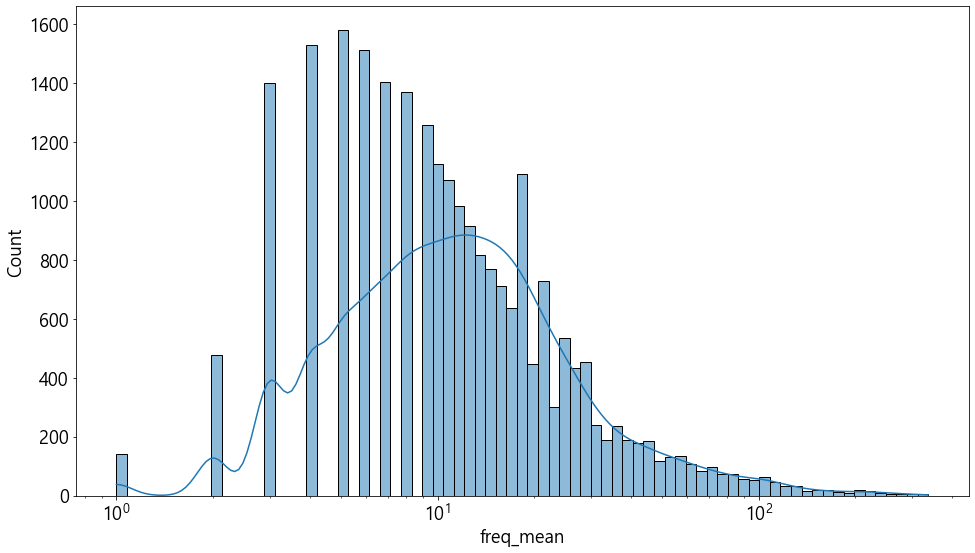

In [163]:
df_cust_visit["freq_mean"].dt.days.dropna().apply(lambda x: x+1)
# sns.histplot(df_cust_visit["freq_mean"].dt.days.dropna().apply(lambda x: x+1), kde=True, log_scale=True)
# plt.show()

# 2.구매 1건에 대한 구매 예측
---

In [28]:
# 군집 샘플 만들기
df_cust["cluster"] = np.random.choice(range(0,30), df_cust["cust"].nunique())
df_mprch = df_prch.merge(df_cust[["cust", "cluster"]], how="left", on="cust")
df_mprch.head()

,cust,rct_no,chnl_dv,cop_c,br_c,pd_c,de_dt,de_hr,buy_am,buy_ct,cluster
0,M430112881,A01000001113,1,A01,A010039,PD0290,2021-01-01,10,15000.0,1,20
1,M646853852,A01000002265,1,A01,A010025,PD1369,2021-01-01,10,79700.0,1,18
2,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,20
3,M430112881,A01000003148,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,20
4,M430112881,A01000004946,1,A01,A010039,PD0290,2021-01-01,10,19000.0,1,20


In [52]:
from datetime import datetime

def make_ts_column(df, date="de_dt", hour="de_hr", drop=False):
    
    if df[date].dtypes=="str" and df[hour].dtypes=="int64":
        df["de_dthr"]=pd.to_datetime(df[date]+":"+df[hour].apply(str), format="%Y-%m-%d:%H")
    elif df[date].dtypes=="<M8[ns]" and df[hour].dtypes=="int64":
        df["de_dthr"]=pd.to_datetime(df[date].apply(lambda x: datetime.strftime(x, format="%Y-%m-%d"))+":"+df[hour].apply(str),format="%Y-%m-%d:%H")
    else:
        raise TypeError(f"Check args type -> {date} column must be 'str' or '<M8[ns]' type. {hour} column must be 'int' type.") 
    
    if drop:
        return df.drop(["de_dt", "de_hr"], axis=1)
    else:
        return df

In [ ]:
make_ts_column(df_prch).groupby()